## References

Quote Mid Price = Spot Price + Basis + Skew  
https://blog.bitmex.com/how-to-market-make-bitcoin-derivatives-lesson-2/  
https://www.bitmex.com/app/fairPriceMarking  
https://www.bitmex.com/app/perpetualContractsGuide  
https://github.com/BitMEX/sample-market-maker  

BuyPrice = Mid-Market + A x Forecast – B x MCR – Current half-spread  
SellPrice = Mid-Market + A x Forecast – B x MCR + Current half-spread  
**https://ieor.columbia.edu/files/seasdepts/industrial-engineering-operations-research/pdf-files/Borden_D_FESeminar_Sp10.pdf ****  

https://www.reddit.com/r/algotrading/comments/6q8dp6/market_making_theory_and_application_readings/

## Implementation
https://github.com/nkaz001/sample-market-maker

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
last_price = pd.read_csv("last_price.csv", index_col='timestamp', converters={'timestamp': pd.to_datetime})
ohlc = last_price.resample('5s', label='right').ohlc().ffill()

In [3]:
fair_basis = pd.read_csv("fair_basis.csv", index_col='timestamp', converters={'timestamp': pd.to_datetime})
fair_basis_ = fair_basis.resample('5s', label='right').ffill()

In [4]:
df = ohlc.merge(fair_basis_, left_on='timestamp', right_on='timestamp', how='outer')
df["fairBasis"] = df["fairBasis"].ffill()
df.columns = ['open', 'high', 'low', 'close', 'fairBasis']

/home/kaz/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [5]:
df

,open,high,low,close,fairBasis
timestamp,,,,,
2020-12-07 00:00:05+00:00,19393.5,19401.0,19393.5,19401.0,NaN
2020-12-07 00:00:10+00:00,19400.5,19409.0,19400.5,19408.5,NaN
2020-12-07 00:00:15+00:00,19409.0,19412.0,19408.5,19411.5,NaN
2020-12-07 00:00:20+00:00,19412.0,19424.5,19411.5,19424.5,NaN
2020-12-07 00:00:25+00:00,19424.0,19432.0,19424.0,19431.5,NaN
...,...,...,...,...,...
2020-12-07 23:59:25+00:00,19191.5,19192.0,19191.5,19192.0,0.97
2020-12-07 23:59:30+00:00,19191.5,19192.0,19191.5,19192.0,0.97
2020-12-07 23:59:35+00:00,19191.5,19192.0,19191.5,19192.0,0.97


In [6]:
class Backtest:
    def __init__(self, equity=None, max_position=None, A=None, B=None, half_spread=None):
        self.equity = equity
        self.max_position = max_position
        self.A = A
        self.B = B
        self.half_spread = half_spread
        
    def set_params(self, A, B, half_spread):
        self.A = A
        self.B = B
        self.half_spread = half_spread
        return self
        
    def get_params(self, deep=True):
        return { 'equity': self.equity, 'max_position': self.max_position, 'A': self.A, 'B': self.B, 'half_spread': self.half_spread }
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        #orders = []
        tick_size = 0.5
        running_qty = 0
        static_equity = self.equity
        fee = 0
        equity = []
        order_qty = 100
        new_bid = np.nan
        new_ask = np.nan
        for _, row in X.iterrows():
            #for price, qty in orders:
            #    if qty > 0 and price >= row['low']:
            #        running_qty += qty
            #        static_equity -= qty / price
            #        fee += qty / price * -0.00025    
            #    if qty < 0 and price <= row['high']:
            #        running_qty -= qty
            #        static_equity += qty / price
            #        fee += qty / price * -0.00025    
            if new_bid > row['low']:
                running_qty += order_qty
                static_equity += order_qty / new_bid
                fee += order_qty / new_bid * -0.00025    
            if new_ask < row['high']:
                running_qty -= order_qty
                static_equity -= order_qty / new_ask
                fee += order_qty / new_ask * -0.00025    
            equity.append(static_equity - running_qty / row['close'] - fee)
            skew = self.B * running_qty / self.max_position * -1
            quote_mid_price = row['close'] + self.A * row['fairBasis'] + skew
            new_bid = np.minimum(np.round(quote_mid_price * (1 - self.half_spread) / tick_size) * tick_size, row['close'] - tick_size)
            new_ask = np.maximum(np.round(quote_mid_price * (1 + self.half_spread) / tick_size) * tick_size, row['close'] + tick_size)
            #if running_qty < self.max_position:
            #    orders.append((new_bid, 100))
            #if running_qty > -self.max_position:
            #    orders.append((new_ask, -100))
            if running_qty > self.max_position:
                new_bid = np.nan
            if running_qty < -self.max_position:
                new_ask = np.nan
        return pd.Series(equity, index=X.index)
    
    def score(self, X):
        returns = self.predict(X).pct_change()
        return np.divide(returns.mean(), returns.std())

In [7]:
#parameters = { 'A': np.linspace(0.01, 1, 100), 'B': np.linspace(0.01, 1, 100), 'half_spread': np.linspace(0.001, 0.01, 10) }
#search = GridSearchCV(Backtest(10000, 10000), parameters)
#search.fit(df)

param_dist = { 'A': stats.uniform(0, 1), 'B': stats.uniform(0, 1), 'half_spread': stats.uniform(0, 0.01) }
search = RandomizedSearchCV(Backtest(10000, 10000), param_distributions=param_dist, n_iter=1000, n_jobs=10)
search.fit(df)

RandomizedSearchCV(estimator=<__main__.Backtest object at 0x7f1898098af0>,
                   n_iter=1000, n_jobs=10,
                   param_distributions={'A': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1898098a00>,
                                        'B': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1898098d00>,
                                        'half_spread': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1898098f70>})

In [8]:
search.best_params_

{'A': 0.10954228838346891,
 'B': 0.4322578579368238,
 'half_spread': 0.0002352486819630262}

In [9]:
search.best_estimator_.score(df)

0.0131697612488153

In [10]:
equity = search.best_estimator_.predict(df)

<AxesSubplot:xlabel='timestamp'>

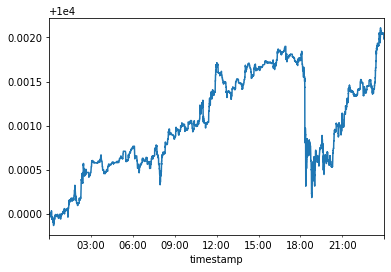

In [11]:
equity.plot()